# __Discover NLP with Python Week 4 - Neural Matchine Translation (NMT)__

In this tutorial we will be predicting English word translation from Spanish using the popular neural network LSTM. 


This tutorial contains 4 parts:  

1. <font color='skyblue'>Data Pre-Processing and Exploratory Data Analysis (EDA)</font>
2. <font color='mediumpurple'>Text Representation & Feature Engineering</font>
3. <font color='darksalmon'>Model</font>
4. <font color='hotpink'>Plot Results and Make Predictions</font>

![picture](https://drive.google.com/uc?export=view&id=1wByRTAx0CJ1OE2LCRYeSNGZUA2nTs9mE)


## <font color='skyblue'>__Data Pre-processing and EDA__ </font>

We will need to explore and understanad the data we have in order to feed the data into the training model


#### <font color='skyblue'>__Donwload and view data__</font>  

We start by downloading the data and viewing the raw data.  

It is important to understand how the raw data is structured and where exactly the data we use are located in order to determine which rows to select for data processing.  


In [ ]:
# get the dataset 
!wget http://www.manythings.org//anki/spa-eng.zip
!unzip spa-eng.zip  # unzip the file 

--2020-12-09 05:02:41--  http://www.manythings.org//anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 172.67.173.198, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4845402 (4.6M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   4.62M  15.2MB/s    in 0.3s    

2020-12-09 05:02:42 (15.2 MB/s) - ‘spa-eng.zip’ saved [4845402/4845402]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


Let's briefly take a look at the data by getting the first and last 10 rows


In [ ]:
# view first 10 lines of the txt
!head -10 spa.txt
# view last 10 lines of the txt
!tail -10 spa.txt

Go.	Ve.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)
Go.	Vete.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)
Go.	Vaya.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)
Go.	Váyase.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)
Hi.	Hola.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)
Run!	¡Corre!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1685404 (Elenitigormiti)
Run!	¡Corran!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #5213896 (cueyayotl)
Run!	¡Corra!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005613 (Seael)
Run!	¡Corred!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005615 (Seael)
Run.	Corred.	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #6681472 (arh)
You can't view Flash content on an iPad. However, you can easily em

From the result above we can see there are 3 columns on the text file. Even without the header we know that the first and second columns are the data we need. 

Now we use Python to read the data.

<font color="gray">__*Delimiter*__  
Pay attention to the delimiter of the file - a character to define the boundaries between strings as it defines how we should instruct the computer to process the file. Common delimiters are `tab` and comma `,`.  

The text file we are processing uses `tab` as the delimiter.</font>

In [ ]:
import numpy as np

# read the text file in English - Spanish pairs
def load_doc(filename):
  '''load text document'''
  file = open(filename, mode='rt')  # rt = read as text
  text = file.read()
  file.close()
  return text

def to_pairs(doc):
  '''split the text file into sentences'''
  lines = doc.strip().split('\n')
  pairs = [line.split('\t') for line in lines]  # "\t" is the delimiter 
  return pairs

# load dataset
filename = 'spa.txt'
doc = load_doc(filename)

# split document contents into english-spanish pairs
text = to_pairs(doc)
pairs = np.array(text) #convert sentences from tuple to array
pairs = pairs[:100000,:2] # taking the first 100k sentences and first 2 columns (english and spanish) for training
# view the first 20 lines of the text document
for i in range(20):
  print('%s\t%s' %(pairs[i,0], pairs[i,1]))

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run!	¡Corran!
Run!	¡Corra!
Run!	¡Corred!
Run.	Corred.
Who?	¿Quién?
Wow!	¡Órale!
Fire!	¡Fuego!
Fire!	¡Incendio!
Fire!	¡Disparad!
Help!	¡Ayuda!
Help!	¡Socorro! ¡Auxilio!
Help!	¡Auxilio!
Jump!	¡Salta!
Jump.	Salte.


#### <font color='skyblue'>__Clean the data__</font>  

Human brains can easily process the importance of punctuations and spaces to a phrase in any languages, in fact it is critical to include the punctuation as part of the word in languages like French and Spanish. But to computer both alphabets and punctuations are no difference as they are "translated" to unicodes. The more complex a phrase the easier to confuse the computer what it wants to do.  

To simplify the process and to achieve the optimal result we usually only use alphabets to perform machine translations.


Remove List:
  * remove white space
  * normalize unicode characters
  * remove punctuations
  * remove printable characters
  * remove numbers

In [ ]:
import string, re
import numpy as np
from numpy import array, argmax, random, take
import matplotlib.pyplot as plt
from unicodedata import normalize
%matplotlib inline

# define all definitions for processing documents

def clean_pairs(lines):
  '''remove characters such as punctuation, spaces and printables from the text file'''
  clean_list = []
  re_punc = re.compile('[%s]'%re.escape(string.punctuation))  # remove punctuation
  re_print = re.compile('[^%s]'%re.escape(string.printable)) # remove printable

  # do cleaning by lines in the document
  for pair in lines:
    clean_pair = []
    for line in pair:
      # normailize unicode characters and decode the UTF-8 characters
      line = normalize('NFD',line).encode('ascii','ignore')
      line = line.decode('UTF-8')

      # remove white space
      line = line.split()
      # convert characters into lower space
      line = [word.lower() for word in line]
      # remove punctuations
      line = [re_punc.sub('',w) for w in line]
      # remove non-printable characters from each token
      line = [re_print.sub('',w) for w in line]
      # remove characters with numbers
      line = [word for word in line if word.isalpha()]
      
      # store pair as string
      clean_pair.append(' '.join(line))

    # add cleanpair to clean_list
    clean_list.append(clean_pair)

  return array(clean_list)


# split into english-spanish pairs
cleaned = clean_pairs(pairs)
print('English\tSpanish')
for i in range(20):
  print('%s\t%s' %(cleaned[i,0], cleaned[i,1]))

English	Spanish
go	ve
go	vete
go	vaya
go	vayase
hi	hola
run	corre
run	corran
run	corra
run	corred
run	corred
who	quien
wow	orale
fire	fuego
fire	incendio
fire	disparad
help	ayuda
help	socorro auxilio
help	auxilio
jump	salta
jump	salte


#### <font color='skyblue'>__Exploratory Data Analysis (EDA)__</font>  

[EDA](https://www.itl.nist.gov/div898/handbook/eda/section1/eda11.htm) helps you to understand the data by visualizing them in order to apply proper machine techniques also perform machine learning on subset data only if necessary.  

EDA is not mandatory for this tutorial but we will demonstrate one example for practice purpose.

We will be looking at the length of the data (number of words)

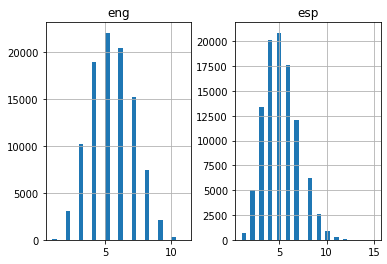

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

eng_list , esp_list = [], []  # create empty lists for english and spanish
# add all english words in to the english list
for i in cleaned[:,0]:
  eng_list.append(len(i.split()))
# add all spanish words in to the spanish list
for i in cleaned[:,1]:
  esp_list.append(len(i.split()))
length_df = pd.DataFrame({'eng':eng_list, 'esp':esp_list})

# plot 
length_df.hist(bins=30)
plt.show()
eng_length, esp_length = max(eng_list), max(esp_list)

## <font color='mediumpurple'>__Text Representation and Feature Engineering__</font>
 
With the cleaned dataset we will be applying couple data minig techniques to prepare the data feeding into the algorithms.

#### <font color='mediumpurple'>__Train / Split Data__</font>

We will be dividing the data into training data and testing data with the ratio of 70% and 30% respectively.

In [ ]:
from sklearn.model_selection import train_test_split
train_list, test_list = train_test_split(cleaned, test_size=0.30, random_state=0)

#### <font color='mediumpurple'>__Tokenization__</font>  

For each English/Spanish phrase in the dataset we will break down into individual words.


In [ ]:
from keras.preprocessing.text import Tokenizer

def tokenization(line):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(line)
  return tokenizer

# tokenization for both english texts and spanish texts
eng_tokenizer = tokenization(cleaned[:,0])
esp_tokenizer = tokenization(cleaned[:,1])

# check the number of words
eng_vocab_size = len(eng_tokenizer.word_index) + 1
esp_vocab_size = len(esp_tokenizer.word_index) + 1
print('English vocabulary size:',eng_vocab_size)  # due to padding=0 we are using + 1

English vocabulary size: 10730


#### <font color='mediumpurple'>__Encoding Sequences__</font>  

Standardize data into a same length and converting textual form into numerical form.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)  # stores the codes in seq
  seq = pad_sequences(seq, maxlen=length,padding='post')
  return seq

# split esp data as training data and english data as the labels
train_X = encode_sequences(tokenizer=esp_tokenizer, length=8, lines=train_list[:,1])
train_y = encode_sequences(tokenizer=eng_tokenizer, length=8, lines=train_list[:,0])

test_X = encode_sequences(tokenizer=esp_tokenizer, length=8, lines=test_list[:,1])
test_y = encode_sequences(tokenizer=eng_tokenizer, length=8, lines=test_list[:,0])

In [ ]:
# print data size and sample
print('Size of the training data is %s \nSample of the training data is %s'%(train_X.shape,train_X[0]))
print('Size of the training label is %s \nSample of the training label is %s'%(train_y.shape,train_y[0]))

Size of the training data is (70000, 8) 
Sample of the training data is [  12    1 2195    5    4    0    0    0]
Size of the training label is (70000, 8) 
Sample of the training label is [  1  33  14   2 123   5   0   0]


## <font color='darksalmon'>__Model__</font> 

We will be using LSTM (Long Short Term Memory) to train our dataset.

#### <font color='darksalmon'>__Define Model and Model Layers__</font>

In [ ]:
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.models import Sequential
from keras import optimizers
import warnings

warnings.filterwarnings('ignore')

# model architecture 
model = Sequential()  # set model as sequential
# add layers on model
model.add(Embedding(esp_vocab_size,512,input_length=8))  # embedding layer
model.add(LSTM(512))
model.add(RepeatVector(8))
model.add(LSTM(512,return_sequences=True))
model.add(Dense(eng_vocab_size,activation='softmax'))  # we will get word with max probability out of all the words in english vocabs

# compile model layers with setting optimizer and loss method
model.compile(optimizer=optimizers.RMSprop(0.001), loss='sparse_categorical_crossentropy')


#### <font color='darksalmon'>__Train the model and Save the Best Model__</font>

In [ ]:
from keras.callbacks import ModelCheckpoint

# save the best model based on minimum loss from model
checkpoint = ModelCheckpoint('model.h1',monitor='val_loss',verbose=1,save_best_only=True,mode='min')

# fit model
history = model.fit(train_X,
          train_y.reshape(train_X.shape[0],train_y.shape[1],1),
          epochs=30,
          batch_size=512,
          validation_split=0.33,
          callbacks=[checkpoint],
          verbose=1)

Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 4.6178
Epoch 00001: val_loss improved from inf to 4.29276, saving model to model.h1
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model.h1/assets
92/92 [==============================] - 636s 7s/step - loss: 4.6178 - val_loss: 4.2928
Epoch 2/30
69/92 [=====================>........] - ETA: 2:14 - loss: 4.1322

## <font color='hotpink'>__Plot Results and Make Predictions__</font>  

Load results and make predictions based on the model

#### <font color='hotpink'>__Load Trained Model__</font>

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
model = load_model("model.h1")

#### <font color='hotpink'>__Plot Result__</font>



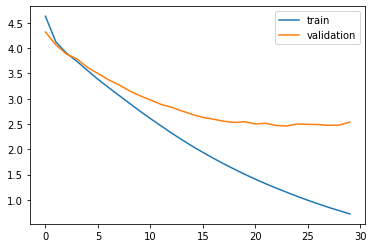

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

#### <font color='hotpink'>__Make Predictions__</font>

In [ ]:
preds = model.predict_classes(text_X)
def get_word(n, tokenizer):
  '''read words'''
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
  return None

# make prediction
preds_text = []
for i in preds:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], eng_tokenizer)
    # add the predicted word to temp list if the word is not None
    if j > 0:
      if (t == get_word(i[j-1], eng_tokenizer)) or (t==None):
        temp.append('')
      else:
        temp.append(t)
    
  preds_text.append(' '.join(temp))

# print results in dataframe
pred_df = pd.DataFrame({'spanish':test[:,1],'actual' : test[:,0], 'predicted' : preds_text})

pred_df

NameError: ignored